In [1]:
from glob import glob
from sklearn.model_selection import GroupKFold, StratifiedKFold
import cv2
from skimage import io
import torch
from torch import nn
import os
from datetime import datetime
import time
import random
import cv2
import torchvision
from torchvision import transforms
import pandas as pd
import numpy as np
from tqdm import tqdm

import matplotlib.pyplot as plt
from torch.utils.data import Dataset,DataLoader
from torch.utils.data.sampler import SequentialSampler, RandomSampler
from torch.cuda.amp import autocast, GradScaler
from torch.nn.modules.loss import _WeightedLoss
import torch.nn.functional as F

#import timm

import sklearn
import warnings
import joblib
from sklearn.metrics import roc_auc_score, log_loss
from sklearn import metrics
import warnings
import cv2
import pydicom
#from efficientnet_pytorch import EfficientNet
from scipy.ndimage.interpolation import zoom
from PIL import Image
import albumentations
import gc

In [2]:
train_csv = pd.read_csv("../input/cassava-leaf-disease-classification/train.csv")
train_csv.shape

(21397, 2)

In [3]:
train_csv = train_csv[:1000]

In [4]:
CFG = {
    'fold_num': 5,
    'seed': 719,
    'model_arch': 'tf_efficientnet_b4_ns',
    'img_size': 512,
    'epochs': 10,
    'train_bs': 16,
    'valid_bs': 32,
    'T_0': 10,
    'lr': 1e-4,
    'min_lr': 1e-6,
    'weight_decay':1e-6,
    'num_workers': 4,
    'accum_iter': 2, # suppoprt to do batch accumulation for backprop with effectively larger batch size
    'verbose_step': 1,
    'device': 'cuda:0'
}

# **Helper function**

In [5]:
def seed_everything():
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
    
    
def get_img(path):
    im_brg = cv2.imread(path)

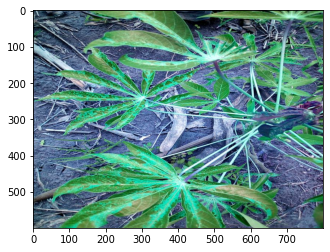

In [6]:
img = cv2.imread("../input/cassava-leaf-disease-classification/train_images/1000201771.jpg")
plt.imshow(img)

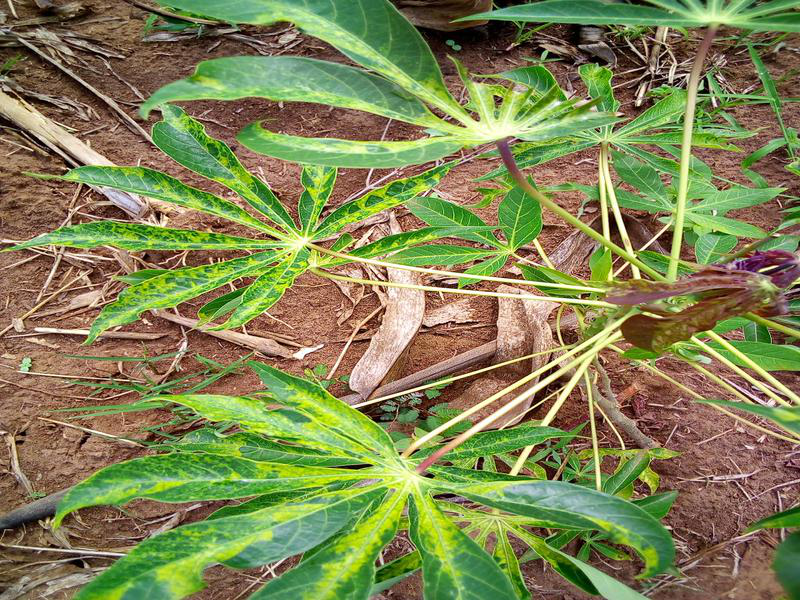

In [7]:
img2 = "../input/cassava-leaf-disease-classification/train_images/1000201771.jpg"
img2 = Image.open(img2)
img2

In [8]:
transform = transforms.Compose([transforms.Resize((256,256))])


In [9]:
im = transform(img2)

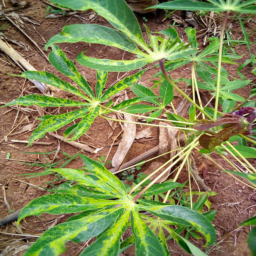

In [10]:
im

In [11]:
from sklearn.preprocessing import OneHotEncoder

In [12]:
target = train_csv.label

In [13]:
target = pd.get_dummies(train_csv.label)

In [14]:
np.array(target)

array([[1, 0, 0, 0, 0],
       [0, 0, 0, 1, 0],
       [0, 1, 0, 0, 0],
       ...,
       [0, 0, 0, 1, 0],
       [0, 0, 0, 1, 0],
       [0, 0, 0, 1, 0]], dtype=uint8)

In [15]:
train_csv = train_csv[:1000] 

In [16]:
image_path = "../input/cassava-leaf-disease-classification/train_images/"

In [17]:
from sklearn import model_selection
from sklearn import ensemble

In [18]:
train_csv["kfold"] = -1

train_csv = train_csv.sample(frac=1).reset_index(drop= True)
y = train_csv.label

kf = model_selection.StratifiedKFold(n_splits=5)

for f, (t_,v_) in enumerate(kf.split(X=train_csv, y=y)):
    train_csv.loc[v_, 'kfold'] = f

In [19]:
train_csv

,image_id,label,kfold
0,1110421964.jpg,3,0
1,1134204099.jpg,4,0
2,1052854295.jpg,0,0
3,1091388730.jpg,3,0
4,1011602291.jpg,2,0
...,...,...,...
995,1065474134.jpg,3,4
996,1080179563.jpg,3,4
997,1047550741.jpg,3,4
998,1117635403.jpg,3,4


In [21]:
img = Image.open("../input/cassava-leaf-disease-classification/train_images/1000201771.jpg")

In [22]:
img = np.array(img)

In [23]:
img = np.transpose(img, (2,0,1)).astype(np.float32)

In [24]:
img.shape

(3, 600, 800)

In [25]:
import torch
import torchvision

class ClassificationDataset:
    def __init__(self, image_path, targets, augmentations = None, transforms = None):
        self.image_path = image_path
        self.targets = targets
       # self.resize = resize
        self.augmentations = augmentations
        self.transforms = transforms
        
        
    def __len__(self):
        return len(self.image_path)
    
    def __getitem__(self, item):
        
        image = Image.open(self.image_path[item])
        
        targets = self.targets[item]
        
#         targets = pd.get_dummies(targets)
#         targets = np.array(targets)
        
        if self.transforms is not None:
            
            transform = self.transforms(image=image)
            image = transform["image"]
            
            
            

            
        image = np.array(image)
        
        if self.augmentations is not None:
            
            augment = self.augmentations(image = image)
            image = augment["image"]
            
        image = np.transpose(image, (2,0,1)).astype(np.float32)
        
        
        return {
            
            "image": torch.tensor(image, dtype = torch.float),
            "target": torch.tensor(targets, dtype = torch.long),
        }

In [26]:
images = train_csv.image_id.values.tolist()
data_path = "../input/cassava-leaf-disease-classification/train_images/"
images = [
    os.path.join(data_path,i) for i in images
]

#targets = train_csv.label.values

targets = pd.get_dummies(train_csv.label)
targets = targets.values

mean = (0.485, 0.456, 0.406)
std = (0.229, 0.229, 0.225)

aug = albumentations.Compose(
    [  
        albumentations.Normalize(
        mean, std, max_pixel_value=255.0,always_apply=True
        ),
         albumentations.Resize(height=256, width=256, always_apply=True)
    ], p= 1.
)


transform = transforms.Compose([transforms.Resize((256,256))])

train_dataset = ClassificationDataset(
            image_path=images,
            targets=targets,
            #transforms=transform,
            augmentations=aug,
#             transforms=transform(),
    )


In [27]:
train_loader = torch.utils.data.DataLoader(train_dataset,
                                          batch_size = 10,
                                          shuffle = True,
                                          num_workers = 4)

In [28]:
import torch.nn as nn

def train(data_loader, model, optimizer, device, loss_output=0):
    
    model.train()
    
   
    
    for data in data_loader:
        inputs = data["image"]
        targets = data["target"]
        
        inputs = inputs.to(device, dtype = torch.float)
        targets = targets.to(device, dtype = torch.float)
        
        
        optimizer.zero_grad()
        
        outputs = model(inputs)
        
        loss = nn.BCEWithLogitsLoss()(outputs, targets)
        
        loss_output = loss + loss_output
        
        loss.backward()
        
        optimizer.step()
        
        
    return loss_output
        
def evaluate(data_loader, model, device):
    
    
    model.eval()
    
    final_target = []
    final_output = []
    
    with torch.no_grad():
        
        for data in data_loader:
            
            inputs = data["image"]
            targets = data["target"]
            inputs = inputs.to(device, dtype = torch.float)
            targets = targets.to(device, dtype = torch.float)
            targets = targets.view(-1,1)
            output = model(inputs)
            
            targets = targets.detach().cpu().numpy().tolist()
            
            output = output.detach().cpu().numpy().tolist()
            
            
            final_target.extend(targets)
            final_output.extend(output)
            
    return final_output, final_target

In [29]:
pip install pretrainedmodels

     |████████████████████████████████| 58 kB 2.5 MB/s eta 0:00:011
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60963 sha256=5949b72c9d6e6affac3c5ea5cd97eae5cacd71570b99f42596ec40221a8c4eec
  Stored in directory: /root/.cache/pip/wheels/ed/27/e8/9543d42de2740d3544db96aefef63bda3f2c1761b3334f4873
Successfully built pretrainedmodels
Note: you may need to restart the kernel to use updated packages.


In [30]:
import pretrainedmodels

def get_model(pretrained):
    if pretrained:
        model = pretrainedmodels.__dict__["resnet18"](
                pretrained="imagenet"
        )
        
    else:
        model = pretrainedmodels.__dict__["resnet18"](
                pretrined = None
        )
        
    model.last_linear = nn.Sequential(
                nn.BatchNorm1d(512),
            nn.Dropout(p=0.25),
            nn.Linear(in_features = 512, out_features = 512 ),
            nn.ReLU(),
                nn.BatchNorm1d(512),
            nn.Dropout(p=0.5),
            nn.Linear(in_features = 512, out_features = 5 ),
            )
    return model

In [31]:
device = "cuda"
model = get_model(pretrained=True)
model = model.to(device)
#model

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [ ]:
epochs = 10
for fold in range(5):
    for epoch in enumerate(range(epochs)):
  

        train_df = train_csv[train_csv.kfold != fold].reset_index(drop=True)

        test_df = train_csv[train_csv.kfold == fold].reset_index(drop=True)

        images = train_df.image_id.values.tolist()
        data_path = "../input/cassava-leaf-disease-classification/train_images/"
        images = [
            os.path.join(data_path,i) for i in images
        ]

       # targets = train_df.label.values
        targets = pd.get_dummies(train_df.label)
        targets = targets.values
    

        train_dataset = ClassificationDataset(
                    image_path=images,
                    targets=targets,
                    #transforms=transform,
                    augmentations=aug,
        #             transforms=transform(),
            )


        train_loader = torch.utils.data.DataLoader(train_dataset,
                                              batch_size = 10,
                                                   pin_memory=False,
                                              shuffle = True,
                                              num_workers = 4)




        images = test_df.image_id.values.tolist()
        data_path = "../input/cassava-leaf-disease-classification/train_images/"
        images = [
            os.path.join(data_path,i) for i in images
        ]

        
        targets = pd.get_dummies(test_df.label)
        targets = targets.values


        test_dataset = ClassificationDataset(
                    image_path=images,
                    targets=targets,
                    #transforms=transform,
                    augmentations=aug,
        #             transforms=transform(),
            )


        test_loader = torch.utils.data.DataLoader(test_dataset,
                                              batch_size = 10,
                                              pin_memory=False,
                                              shuffle = True,
                                              num_workers = 4)

        optimizer = torch.optim.Adam(model.parameters(), lr= 5e-2)
    #     epochs = 10
    #     for epoch in range(epochs):
        loss = train(train_loader,model, optimizer, device = "cuda", loss_output=0)
        predictions, valid_targets = evaluate(test_loader, model, device="cuda")
        

       # roc_auc = roc_auc_score(valid_targets, predictions)
        print(
            f"epoch = {epoch}",
            f"folds = {fold}",
            f" loss = {loss/10}"
        )
        
        gc.collect()

epoch = (0, 0) folds = 0  loss = 4.337872505187988
epoch = (1, 1) folds = 0  loss = 4.146388053894043
epoch = (2, 2) folds = 0  loss = 3.9913852214813232
epoch = (3, 3) folds = 0  loss = 4.051992416381836
epoch = (4, 4) folds = 0  loss = 4.003983974456787
epoch = (5, 5) folds = 0  loss = 3.9801747798919678
epoch = (6, 6) folds = 0  loss = 3.757890462875366
epoch = (7, 7) folds = 0  loss = 3.974945068359375
epoch = (8, 8) folds = 0  loss = 3.8364408016204834
epoch = (9, 9) folds = 0  loss = 4.029571056365967


In [ ]:
torch.sav